# Facial Keypoints Detection


## Group Members
- Don Moon
- Shwetha Chitta Nagaraj
- Lester Yang


### Introduction

The task of facial keypoints detection is given an image of a human face for example, to build a machine learning model analyzes and detects facial keypoints like centers of the eyes, corners of eyes, tip of nose, corners of lips etc. This kind of detection finds lot of applications like:
* Medical diagnosis of facial disfigurement
* Tracking line of sight
* Analyzing facial expressions
* Face tracking in videos
* Biometrics/ face recognition
* Snapchat

Along with a wide variety of applied needs, detecting facial keypoints is a challenging problem as facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. 

Our primary motivation for the W207 Final project is to learn and apply deep learning modeling techniques to widely significant applications with relevant uses and the Kaggle Facial Keypoints Detection challenge would give us the opportunity to learn and experiment with many advanced approaches associated with Convolutional Neural Networks.

The goal with the [Kaggle dataset](https://www.kaggle.com/c/facial-keypoints-detection/overview/description) is to predict a set of x, y co-ordinates for each facial keypoint in the pixelated image of a given set of 2-D images of human faces. It is required to use $Root Mean Square Error(RMSE)$ to measure the accuracy of the models developed. 


$$ RMSE = \sqrt{\frac{1}{n}. \sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

where $y_i$ is the original value and $\hat{y_i}$ is the predicted value for $n$ given examples. 

## Dataset

- The input images are 96x96 pixels represented in (0,255)
- The following 15 keypoints, represnted in (x,y), should be predicted:

  left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

- 7049 training images and 1783 testing images 



## How to Solve the Problem

- Algorithms: Neural Networks    
- Computing platform: AWS and Google Colab

## Setting Colab Env.

In [0]:
# Requires the latest pip
!pip install --upgrade pip
# Current stable release for tf GPU
!pip install tensorflow-gpu

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
tf.test.gpu_device_name()


#from keras.backend.tensorflow_backend import set_session
import sys, time, os, warnings, cv2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Make sure tf > 2.0
print("python {}".format(sys.version))
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
tensorflow version 2.1.0


In [0]:
# set global mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [0]:
# mount google drive in runtime
# click URL to copy auth code
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# find location of csv file on your drive
!ls "/content/drive/My Drive/Colab Notebooks/W207"
sys.path.append('/content/drive/My Drive/Colab Notebooks/W207')

face_model.py		 IdLookupTable.csv	     test.csv
FCN_model.ipynb		 memory_saving_gradients.py  test.ipynb
gradient_chkpnt_testing  __pycache__		     training.csv


## Exploratory Data Analysis

In [0]:
# insert file location into read_csv
# load file to dataframe
FTRAIN = '/content/drive/My Drive/Colab Notebooks/W207/training.csv'
FTEST = '/content/drive/My Drive/Colab Notebooks/W207/test.csv'
FIdLookup = '/content/drive/My Drive/Colab Notebooks/W207/IdLookupTable.csv'

train_data = pd.read_csv(FTRAIN)
test_data = pd.read_csv(FTEST)
idlookup_tbl = pd.read_csv(FIdLookup)

In [0]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [0]:
# Check train data dimensions
print(" Number of examples/images in train data: ", train_data.shape[0]) # 7049 examples or images

 Number of examples/images in train data:  7049


The train data has 7049 examples or images, each with 15 facial key points along x and y co-ordinates. Image consists of row-ordered pixel values separated by space.

So now the image data will be our input and the facial keypoint coordinates for the 15 facial keypoints will be labels to predict through regression.


Loading Images...


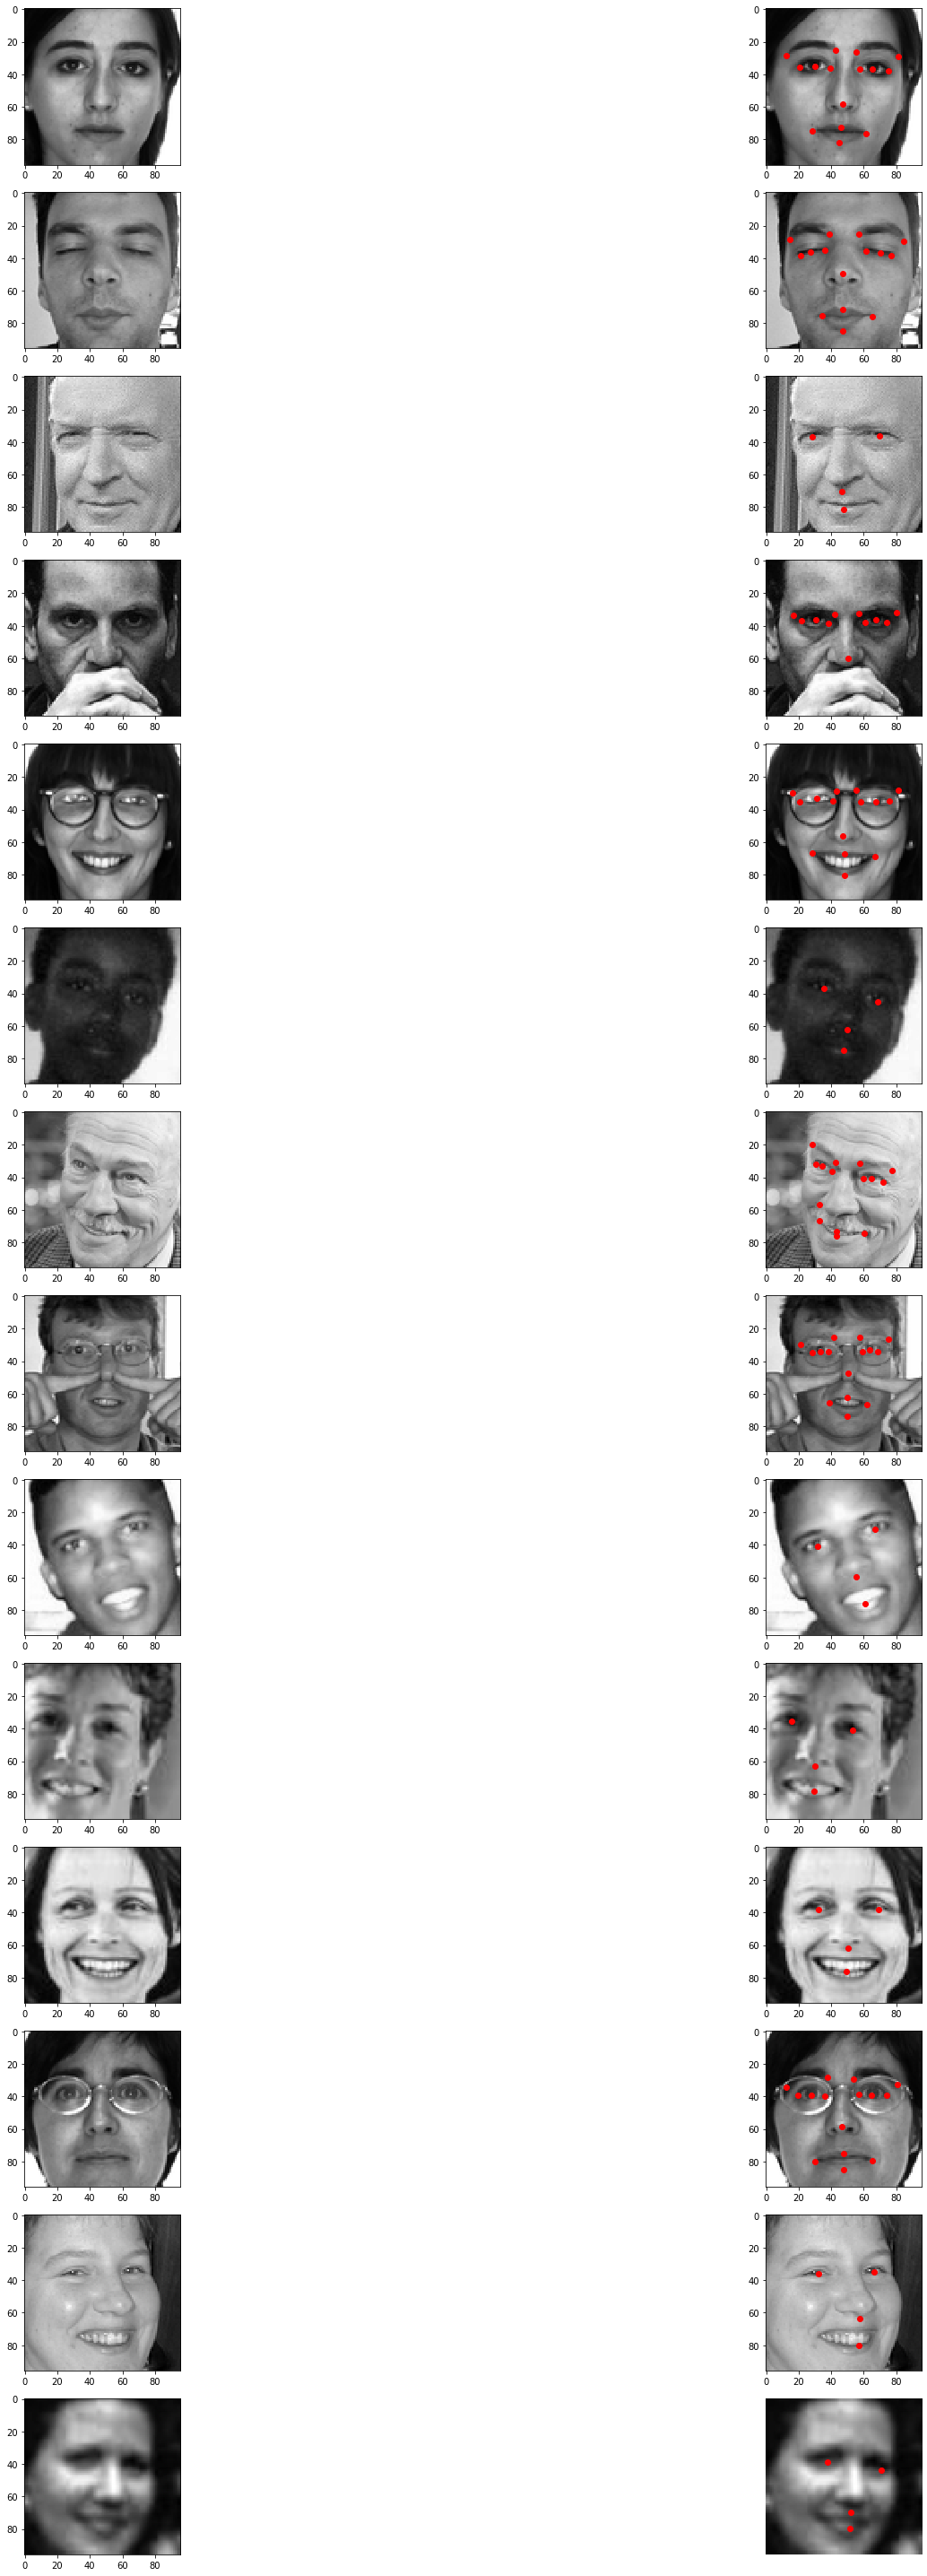

In [0]:
# Display random images with corresponding keypoints from train data
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

# Randomly display 10 images
num_examples = 14
num_columns = 2
#idx = np.random.choice(train_data.index, size = 5, replace=False)
idx =[1563, 66, 5628, 2154, 1233, 5149, 1908, 88, 2885, 4927, 4797, 1266, 3473, 3668]
images = train_data.loc[idx]['Image']
keypoints_list = list(train_data)[:-1]
keypoints = train_data.loc[idx][keypoints_list]
fig, axcs = plt.subplots(figsize=(40, 40), nrows=14, ncols=2)

print("Loading Images...")
for j, (string, (iloc, keypoint)) in enumerate(zip( images, keypoints.iterrows())):
        xy = keypoint.values.reshape((15, 2))
        axcs[j, 0].imshow(string2image(string), cmap='gray')
        axcs[j,1].imshow(string2image(string), cmap='gray')
        axcs[j,1].plot(xy[:, 0], xy[:, 1], 'ro')
        plt.axis('off')
        plt.tight_layout()

From the images above we can see:
* Not all images have all the 15 keypoints
* Differences in image resolution(blurred, contrast, cropped)
* Different poses and expressions(eyes closed, angles, mouth closed, mouth open)
* Different illumination conditions


In [0]:
# Display count of available values for each facial key point coordinate
print(train_data.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

It seems like the facial keypoints are not labeled consistently for all the 7049 examples(images) in the train data.

### Missing Data

In [0]:
# How many facial key points have no data
print("Count of facial key points with missing coordinates:")
print(train_data.isnull().any().value_counts())

Count of facial key points with missing coordinates:
True     28
False     3
dtype: int64


It appears that of the 7049 images, some 2000+ have all 15 keypoints and the other 5000 have only a few keypoints. Let us dive deeper into this.

In [0]:
# Check count of missing data fpr all 15 facial keypoints
train_data.isnull().sum().sort_values(ascending=False)

left_eyebrow_outer_end_y     4824
left_eyebrow_outer_end_x     4824
right_eyebrow_outer_end_y    4813
right_eyebrow_outer_end_x    4813
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
mouth_left_corner_y          4780
mouth_left_corner_x          4780
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
right_eyebrow_inner_end_y    4779
right_eyebrow_inner_end_x    4779
mouth_right_corner_x         4779
mouth_right_corner_y         4779
left_eye_inner_corner_y      4778
left_eye_inner_corner_x      4778
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_y      33
mouth_center_bottom_lip_x      33
right_eye_center_y             13
right_eye_center_x             13
left_eye_center_y              10
left_eye_center_x              10
nose_tip_x                      0
nose_tip_y    

Except for nose_tip, the rest of the keypoints have missing data.

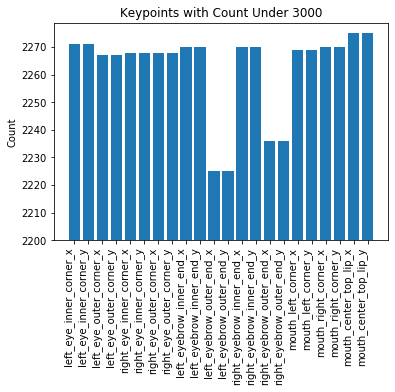

In [0]:
# keypoints with less than 3000 labels
kp = train_data.describe()
less_kp = kp.loc[:, kp.loc['count'] < 3000].loc['count']
more_kp = kp.loc[:, kp.loc['count'] > 3000].loc['count']
_l = np.arange(len(less_kp))
_m = np.arange(len(more_kp))

fig, ax1 = plt.subplots()
ax1.bar(_l, less_kp-2200, bottom=2200)
ax1.set_ylabel('Count')
ax1.set_xticks(_l)
ax1.set_xticklabels(less_kp.index, rotation=90, ha='right')
ax1.set_title("Keypoints with Count Under 3000")
plt.show()

Particularly, left_eyebrow_outer_end and right_eyebrow_outer_end have lower counts.

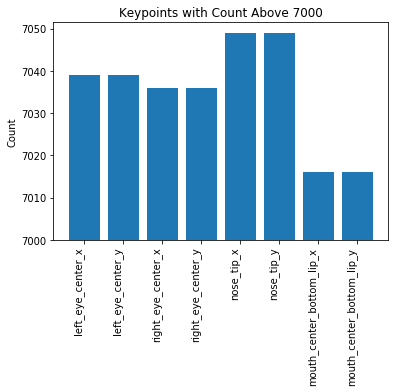

In [0]:
# Keypoints with more than 7000 labels
fig, ax2 = plt.subplots()
ax2.bar(_m, more_kp-7000, bottom=7000)
ax2.set_xticks(_m)
ax2.set_xticklabels(more_kp.index, rotation=90, ha='right')
ax2.set_ylabel('Count')
ax2.set_title("Keypoints with Count Above 7000")
plt.show()

The above plots indicate that in the Kaggle training dataset, only around 2000 images can be called as "high quality" as they have details of all the 15 facial keypoints. The rest which is around 5000 images can be called as "low-quality" with only 8 facial keypoints labelled.

Here it is clear that out of the 30 labels, labels for below 4 facial key points are available across all 7049 images in Kaggle training dataset:
* left_eye_center
* right_eye_center
* nose_tip
* mouth_center_bottom_lip 

The remaining 11 facial keypoints have labels that are available across only around 2000 records.
This observation could influence how we treat our modeling datasets.

### Data Distribution

In [0]:
train_data.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [0]:
# Skewness in the labels
train_labels = train_data.drop('Image', axis=1)
temp = train_labels.to_numpy().T.tolist()
temp = [[x for x in l if str(x) != 'nan'] for l in temp]
label_skewness = [stats.skew(x) for x in temp]

Highly skewed labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_outer_end_x', 'right_eyebrow_outer_end_x']


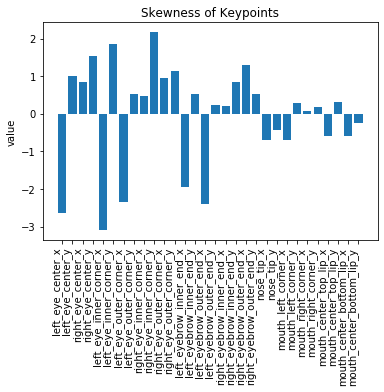

In [0]:
# Plot the skewness
print("Highly skewed labels: ", [label for s,label in zip(label_skewness, train_labels.columns) if abs(s) >= 1])
fig, ax = plt.subplots()
_x = np.arange(len(train_labels.columns))
ax.bar(_x, label_skewness)
ax.set_ylabel("value")
ax.set_xticks(_x)
ax.set_xticklabels(train_labels.columns, rotation=90, ha='right')
ax.set_title('Skewness of Keypoints')
plt.show()

From the standard deviation above $mouth$ and $nose$ keypoints have particularly high spread. This could be due to mouth being open, closed, covered etc. which we saw in some of the images above.

 

Let's take a closer look at these distributions through scatter plots for each of the 15 facial key points to identify outliers from the images.

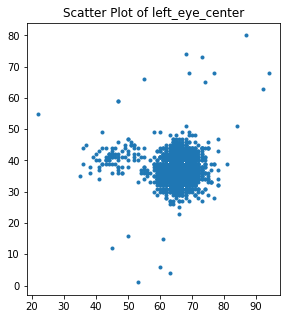

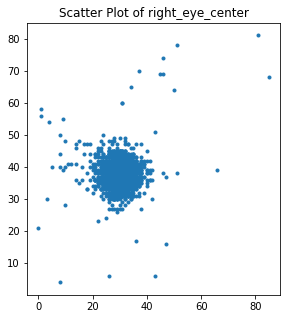

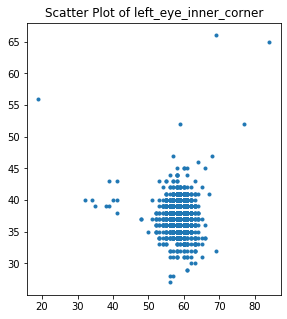

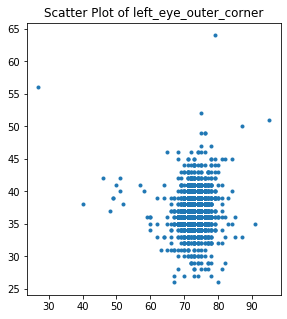

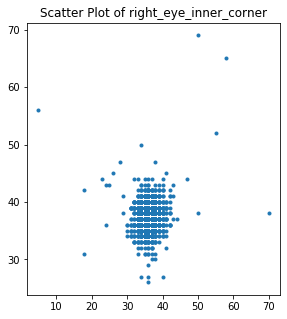

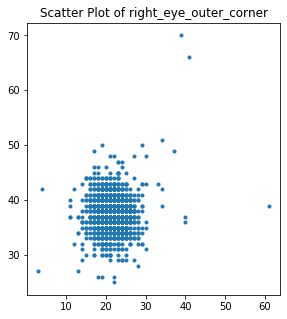

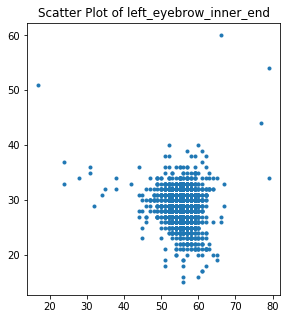

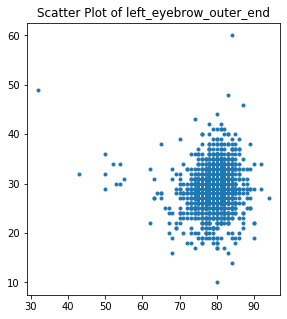

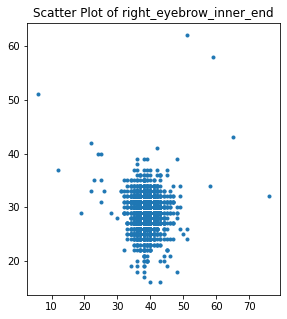

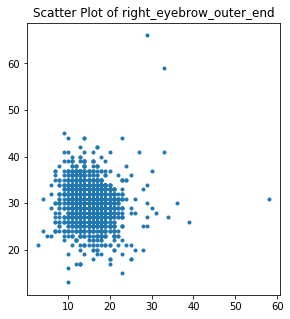

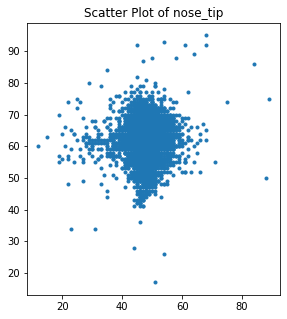

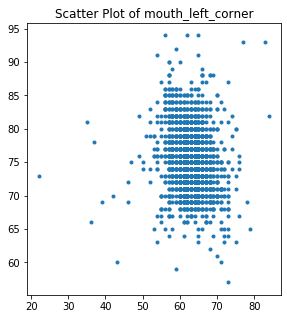

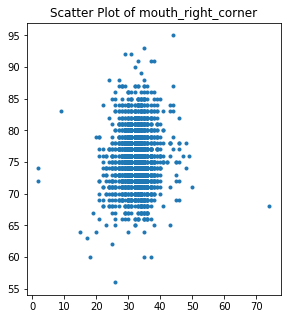

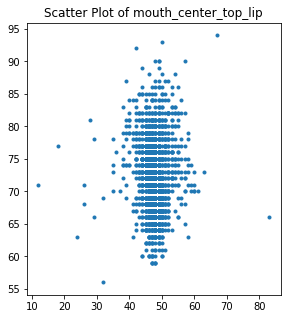

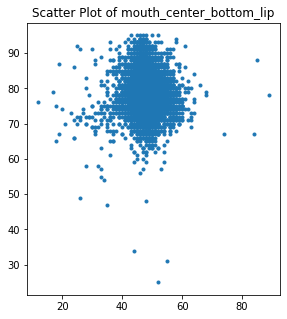

In [0]:
# Scatter plot of all the 15 keypoints(x, y co-ordinates)
columns = list(train_data.columns.values)
for i in range(0, 30, 2):
    # Scatter plot for each feature along x and y co-ordinates
    plt.figure(figsize=(10, 5))
    axes = plt.subplot(1, 2, 1)
    #axes = plt.subplots(figsize=(20, 20), nrows = 5, ncols = 3)
    axes.scatter(x=train_data[columns[i]].dropna().astype('int8'), y=train_data[columns[i+1]].dropna().astype('int8'), marker= '.')
    axes.set_title(('Scatter Plot of '+ columns[i][:-2]))
    
plt.show()

From the scatterplots of the keypoint co-ordinates we can see that they are mostly clustered around a smaller region along with some outliers. 

Also as a final step let's make sure there are no duplicates.

In [0]:
#Check for any duplicate images
duplicate_images = train_labels[train_labels.duplicated()]
print("Number of duplicate images:", len(duplicate_images))

Number of duplicate images: 0


# Summary of EDA
- Among 15 keypoints, the following 4 keypoints are provided by the most of the training images (more than 7000 out of 7049 images)
 - left_eye_center
 - right_eye_center
 - nose_tip
 - mouth_center_bottom_lip
 - The remaining 11 keypoints have less than 2000 images to train with

- Mouth and nose keypoints have particularly high variations due to facial expression


# Data Pre-processing

### Train and Dev Data Split

We will split the train data with a 80:20 split to produce train and development sets.

In [0]:
image_list = []
for i in range(train_data.shape[0]):
  pixel_list = train_data['Image'][i].split(' ')
  pixel_list = ['0' if j == '' else j for j in pixel_list]
  image_list.append(pixel_list)


#### Normalize the pixel values

The example images have pixel values between 0 and 255. Lets scale these values by normalizing them between 0 and 1. This will help with accuracy of the trained models. 

In [0]:
X_master = np.array(image_list, dtype = 'float')
print("Dimensions and values before normalization:")
print("X_master.shape = {}, X_master.min = {:.3f}, X_master.max = {:.3f}"
      .format(X_master.shape, X_master.min(), X_master.max()))
X_master = X_master / 255

Dimensions and values before normalization:
X_master.shape = (7049, 9216), X_master.min = 0.000, X_master.max = 255.000


#### Scale the values of x and y coordinates for the facial keyoints labels

Scaling the coordinates beween -1 and 1 with 0 being the center, since some of the popular activation functions used in our CNN models like relu work best in this range.

In [0]:
# Scale x and y cooridnates of keypoints to be between -1 and 1
Y_master = (train_labels - 96/2) / (96/2)
Y_master = np.array(Y_master, dtype = 'float')

In [0]:
# Data split
# Split image examples and facial keypoints labels into train and dev datasets using 80:20 split
X_train, X_dev, Y_train, Y_dev = train_test_split(X_master, Y_master, test_size=0.2, random_state=42, shuffle=True)
print("X_Train: " + str(X_train.shape) + " Y_Train: " + str(Y_train.shape))
print("X_Dev: " + str(X_dev.shape) + " Y_dev: " + str(Y_dev.shape))

X_Train: (5639, 9216) Y_Train: (5639, 30)
X_Dev: (1410, 9216) Y_dev: (1410, 30)


#### Handling Missing Data

As we noticed missing data for certain facial keypoints, we will remove them in both the train and dev datasets. This will leave us with 30% of the original amount of images for modeling. This is not ideal so it requires us to work on strategies to compensate for the missing data. 

In [0]:
# Now remove the rows with missing data in both train and dev datasets
X_train_trim = X_train[~np.isnan(Y_train).any(axis=1)]
Y_train_trim = Y_train[~np.isnan(Y_train).any(axis=1)]
X_dev_trim = X_dev[~np.isnan(Y_dev).any(axis=1)]
Y_dev_trim = Y_dev[~np.isnan(Y_dev).any(axis=1)]

In [0]:
# Show the dimensions of the new train and dev datasets
print("X_train_trim.shape = {}, Y_train_trim.shape = {}"
      .format(X_train_trim.shape, Y_train_trim.shape))
print("X_dev_trim.shape = {}, Y_dev_trim.shape = {}"
      .format(X_dev_trim.shape, Y_dev_trim.shape))
print(X_dev_trim.shape)
print(Y_dev_trim.shape)

X_train_trim.shape = (1692, 9216), Y_train_trim.shape = (1692, 30)
X_dev_trim.shape = (448, 9216), Y_dev_trim.shape = (448, 30)
(448, 9216)
(448, 30)


So now we have a train dataset with 1692 examples each with 9216(96X96) pixel values along with corresponding 30 labels for the facial keypoints. Dev dataset has 448 images with 96X96 pixel values for each of which we have to predict 30 keypoint labels.

#### Check Kaggle Test data for submission

In [0]:
# Check test data dimensions
test_data.shape # 1783 test examples or images

(1783, 2)

In [0]:
test_data.head().T # Each example contains ImageId and image data with row-ordered list of pixel values

,0,1,2,3,4
ImageId,1,2,3,4,5
Image,182 183 182 182 180 180 176 169 156 137 124 10...,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,177 176 174 170 169 169 168 166 166 166 161 14...,176 174 174 175 174 174 176 176 175 171 165 15...,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


### Development Environment

- AWS EC2 p2.xlarge instance
    - Ubuntu 18.04 
    - Tensorflow 1.15.2
    - Keras 2.2.4-tf

- Google Colab
    - Tensorflow 2.1.0

### Baseline Model

Convolutional Neural Networks are well known in image processing applications like image classification, object detection and recognition.

As compared to Neural Networks where every neuron in one layer is connected to every neuron with next layer we will have a large amount of neurons and parameters especially while handling images. 

CNNs use a small filter that scans through image to find the weights for the small filter. This way the number of parameters to be learnt becomes manageable while retaining high expresiveness while processing large sets of images.

We will model a simple CNN as our baseline model with 1 convoluted layer and 1 fully connected layer. We will use the trimmed datasets without the missing values. 

In [0]:
# reshape data for CNN input
X_train_trim = X_train_trim.reshape(-1,96,96,1)
X_dev_trim = X_dev_trim.reshape(-1,96,96,1)

In [0]:
# Single Layer CNN
np.random.seed(533)

# create baseline CNN model with 1 convoluted layer with relu activation
# input is 96X96 pixel images with 1 channel(gray scale) -> (96, 96, 1) tensors
# applies 10 convolution filters of 3X3 each
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(30))

# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# compile model for the learning process
# 'adam' optimizer is used
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model with 100 epochs and batch size = 32 and using dev dataset as validation set
%time history_cnn = model.fit(X_train_trim, Y_train_trim, epochs=100, shuffle=True, batch_size=32, validation_data=(X_dev_trim, Y_dev_trim), verbose=2)

# Summary of trained model
model.summary()

Train on 1692 samples, validate on 448 samples
Epoch 1/100
1692/1692 - 8s - loss: 2.2699 - rmse: 2.2651 - val_loss: 0.2602 - val_rmse: 0.2602
Epoch 2/100
1692/1692 - 1s - loss: 0.1525 - rmse: 0.1525 - val_loss: 0.1154 - val_rmse: 0.1154
Epoch 3/100
1692/1692 - 1s - loss: 0.1086 - rmse: 0.1085 - val_loss: 0.0920 - val_rmse: 0.0920
Epoch 4/100
1692/1692 - 1s - loss: 0.0768 - rmse: 0.0769 - val_loss: 0.0795 - val_rmse: 0.0795
Epoch 5/100
1692/1692 - 1s - loss: 0.0657 - rmse: 0.0658 - val_loss: 0.0636 - val_rmse: 0.0636
Epoch 6/100
1692/1692 - 1s - loss: 0.0604 - rmse: 0.0604 - val_loss: 0.0671 - val_rmse: 0.0671
Epoch 7/100
1692/1692 - 1s - loss: 0.0516 - rmse: 0.0516 - val_loss: 0.0617 - val_rmse: 0.0617
Epoch 8/100
1692/1692 - 1s - loss: 0.0510 - rmse: 0.0510 - val_loss: 0.0579 - val_rmse: 0.0578
Epoch 9/100
1692/1692 - 1s - loss: 0.0497 - rmse: 0.0497 - val_loss: 0.0696 - val_rmse: 0.0696
Epoch 10/100
1692/1692 - 1s - loss: 0.0493 - rmse: 0.0493 - val_loss: 0.0585 - val_rmse: 0.0585
Ep

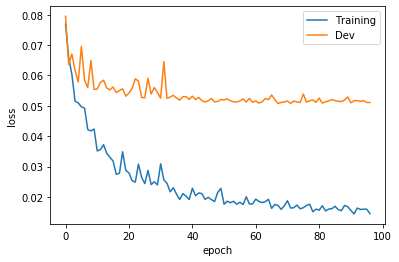

In [0]:
# plot metrics
plt.plot(history_cnn.history['rmse'][3:], label = 'Training')
plt.plot(history_cnn.history['val_rmse'][3:], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

We can see that our model suffers from overfitting our training data. It does not generalize on the Dev dataset. Also we see the Dev data loss increasing aroin after around 80 epochs. We will try to reduce the number of epochs in the next step.

In [0]:
# Single Layer CNN

# create baseline CNN model with 1 convoluted layer with relu activation
# input is 96X96 pixel images with 1 channel(gray scale) -> (96, 96, 1) tensors
# applies 10 convolution filters of 3X3 each
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(30))

# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# compile model for the learning process
# 'adam' optimizer is used
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model with 13 epochs(best after trials) and batch size = 32 and using dev dataset as validation set
%time history_cnn_2 = model.fit(X_train_trim, Y_train_trim, epochs=13, shuffle=True, batch_size=32, validation_data=(X_dev_trim, Y_dev_trim), verbose=2)

# Summary of trained model
model.summary()

Train on 1692 samples, validate on 448 samples
Epoch 1/13
1692/1692 - 1s - loss: 1.5243 - rmse: 1.5211 - val_loss: 0.2041 - val_rmse: 0.2041
Epoch 2/13
1692/1692 - 1s - loss: 0.1363 - rmse: 0.1362 - val_loss: 0.1601 - val_rmse: 0.1601
Epoch 3/13
1692/1692 - 1s - loss: 0.1109 - rmse: 0.1108 - val_loss: 0.0946 - val_rmse: 0.0946
Epoch 4/13
1692/1692 - 1s - loss: 0.0743 - rmse: 0.0743 - val_loss: 0.0704 - val_rmse: 0.0704
Epoch 5/13
1692/1692 - 1s - loss: 0.0619 - rmse: 0.0619 - val_loss: 0.0725 - val_rmse: 0.0725
Epoch 6/13
1692/1692 - 1s - loss: 0.0548 - rmse: 0.0548 - val_loss: 0.0596 - val_rmse: 0.0596
Epoch 7/13
1692/1692 - 1s - loss: 0.0521 - rmse: 0.0521 - val_loss: 0.0579 - val_rmse: 0.0579
Epoch 8/13
1692/1692 - 1s - loss: 0.0463 - rmse: 0.0462 - val_loss: 0.0584 - val_rmse: 0.0584
Epoch 9/13
1692/1692 - 1s - loss: 0.0453 - rmse: 0.0453 - val_loss: 0.0566 - val_rmse: 0.0566
Epoch 10/13
1692/1692 - 1s - loss: 0.0431 - rmse: 0.0431 - val_loss: 0.0589 - val_rmse: 0.0589
Epoch 11/13


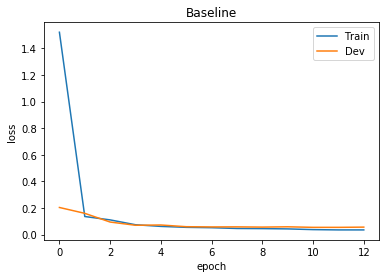

In [0]:
# plot metrics
plt.plot(history_cnn_2.history['rmse'], label = 'Train')
plt.plot(history_cnn_2.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Baseline')
plt.show()

In [0]:
# look at final RMSE value after 13 epochs
#print("Dev Data RMSE: {:.3f}".format(sqrt(history_cnn_2.history.get('val_rmse')[-1]) * 48))
print("Baseline RMSE: {:.3f}".format(np.sqrt(history_cnn_2.history.get('rmse')[-1]) *48))

Baseline RMSE: 9.037


The loss looks much better with RMSE of 9 which will be our baseline. For our model to perform better and reduce overfitting we would need more training data. We plan to use several data augmentation techniques to enhance our training dataset. 

The Kaggle leaderboard RMSE score is 1.28 followed by 1.4. So we have a long way to go to explore better models and optimization techniques.

In [0]:
# Predict on dev data
dev_predict = model.predict(X_dev_trim)

In [0]:
def plot_sample(x_dev, y_dev, y_dev_predict, axis):
    img = x_dev.reshape(96, 96)
    axis.imshow(img, cmap='gray')
   # plt.plot
    axis.scatter(y_dev_predict[0::2] * 48 + 48, y_dev_predict[1::2] * 48 + 48, marker='o', color = 'red', s=50, label = 'predict')
    axis.scatter(y_dev[0::2] * 48 + 48, y_dev[1::2] * 48 + 48, marker='x', color = 'blue', s=50, label = 'orig')

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_dev_trim[i], Y_dev_trim[i], dev_predict[i], ax)

plt.show()

### Next Steps

#### Dealing with Missing Values

* <b>Imputing missing values</b>
    
* <b>Build 2 datasets</b>
    * 1st model will train on 8 keypoint labels 
    * 2nd model will train on 22 keypoint labels
* <b>Data Augmentation</b>
    * Mirroring
    * Rotation
    * Blurring
    * Contrast Reduction

#### CNN Architectures

* LeNet-5
* AlexNet
* VGG
* Inception and GoogLeNet
* Residual Network or ResNet

#### Activation Functions

* ReLU
* LeakyReLU
* Randomized ReLU etc.

#### Batch size / Learning Rate

#### Other Techniques
* Early Stopping
* Dropout
* Specialist Models